<div style="background-color:	#880E4F ; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Transforming Fashion</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
    - [&sect;2.1: Afbeeldingen en hun bounding-boxes](#2.1)
    - [&sect;2.2: Categorieën](#2.2)
    - [&sect;2.3: Afbeeldingen image-captioning](#2.3)
    - [&sect;2.4: Gemeenschappelijke items](#2.4)
    - [&sect;2.5: Conclusie EDA](#2.5)
3. [H3: Object Detectie](#3.0)
    - [&sect;3.1: Model](#3.1)
    - [&sect;3.2: Voorspellingen](#3.2)
    - [&sect;3.3: Afbeeldingen voorverwerken](#3.3)
    - [&sect;3.4: Stappen feature engineering](#3.4)
    - [&sect;3.5: Keuzes parameters, optimizer en epochs](#3.5)
    - [&sect;3.6: Loss functie](#3.6)
4. [H4: Ondertiteling van afbeeldingen](#4.0)
    - [&sect;4.1: Finetuning model](#4.1)
    - [&sect;4.2: Uitleg model](#4.2)
    - [&sect;4.3: Keuzes parameters, optimizer en epochs](#4.3)
5. [H5: Beeldgeneratie](#5.0)
    - [&sect;5.1: Hugging Face Model](#5.1)
    - [&sect;5.2: Naam modelarchitectuur en dataset](#5.2)
    - [&sect;5.3: Stappen finetunen](#5.3)
    - [&sect;5.4: Componenten model](#5.4)
    - [&sect;5.5: Afbeeldingen maken en loss functie](#5.5)
    - [&sect;5.6: Keuzes parameters, optimizer en epochs](#5.6)
6. [H6: Implementatie](#6.0)
    - [&sect;6.1: App](#6.1)
    - [&sect;6.2: Samenvattingen uitkomsten modelleren](#6.2)
    - [&sect;6.3: Overzicht resultaten](#6.3)
    - [&sect;6.4: Kaggle scores](#6.4)
7. [H7: Conclusie en aanbevelingen](#7.0)
    - [&sect;7.1: Uitdagingen en omschrijving modelleringsproces](#7.1)
    - [&sect;7.2: Aanbevolen gebruik](#7.2)
    - [&sect;7.3: Aanbevelingen soort data](#7.3)
    - [&sect;7.4: Resultaten betrouwbaar?](#7.4)
8. [H8: Literatuurlijst](#8.0)

In [1]:
#alle nodige imports
import os
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset

c:\Users\akers\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het vak Deep Learning wordt er in dit portfolio onderzoek gedaan naar de werking en toepassing van verschillende vormen van neurale netwerken. De opdracht voor dit portfolio is het voorspellen van categorieën in kledingstukken met de hulp van neurale netwerken. Dit kunnen neurale netwerken zijn die alleen werken met tekst data, juist alleen met foto data of zelfs met beide. De opdrachten die worden uitgevoerd in dit portfolio zijn:

- Objectdetectie
- Ondertiteling van afbeeldingen
- Beeldgeneratie
- Implementatie

Aan het einde van het Notebook reflecteren wij op de wijze van ons werk en geven wij advies over het gebruiken van onze gemaakte app. 

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: Afbeeldingen en hun bounding-boxes</h3>

In [2]:
def read_bbox_from_file(file_path):
    """
    Reads bounding box data from a file and returns it as a list of bounding boxes.
    The file is expected to have one bounding box per line in the following format:
    class_label, x_center, y_center, width, height

    Parameters:
    -----------
    file_path (str): The path to the file containing bounding box data.

    Returns:
    --------
    tuple: A tuple containing two elements:
        - A list of bounding boxes. Each bounding box is represented as a list in the format
          [class_label, x_center, y_center, width, height], where class_label is an integer
          and the other values are floats.
        - A set of class labels present in the file.
    """
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        bounding_boxes = []
        labels = set()
        for line in lines:
            parts = line.strip().split()
            class_label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            bounding_boxes.append([class_label, x_center, y_center, width, height])
            labels.add(class_label)
    return bounding_boxes, labels

def draw_bounding_boxes(image, boxes):
    """
    Draws bounding boxes on an image with labels and colors. The function uses predefined colors
    and label names for different classes to draw the bounding boxes and their corresponding
    labels on the image.

    Parameters:
    -----------
    image (numpy.ndarray): The image on which to draw the bounding boxes. The image should be a numpy
        array.
    boxes (list): A list of bounding boxes. Each bounding box is represented as a list in the format
        [label, x_center, y_center, width, height], where label is an integer and the other
        values are floats representing the normalized coordinates and dimensions of the box.
    """
    
    label_colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
        6: (128, 0, 0),
        7: (0, 128, 0),
        8: (0, 0, 128),
        9: (128, 128, 0)
    }
    label_names = {
        0: "sunglass",
        1: "hat",
        2: "jacket",
        3: "shirt",
        4: "pants",
        5: "shorts",
        6: "skirt",
        7: "dress",
        8: "bag",
        9: "shoe"
    }

    for box in boxes:
        label, x_center, y_center, width, height = box
        image_height, image_width, _ = image.shape
        x1 = int((x_center - width / 2) * image_width)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)
        
        color = label_colors[label]
        label_name = label_names[label]
        
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        

def find_images_by_categories(category_names):
    """
    Finds and returns one image file path for each specified category name.

    Parameters:
    -----------
    category_names (list): A list of category names to search for.

    Returns:
    --------
    dict: A dictionary where keys are image file paths and values are lists of category names.
    """
    label_names = {
        "sunglass": 0,
        "hat": 1,
        "jacket": 2,
        "shirt": 3,
        "pants": 4,
        "shorts": 5,
        "skirt": 6,
        "dress": 7,
        "bag": 8,
        "shoe": 9
    }

    category_labels = {label_names[name]: name for name in category_names}
    matching_images = {}

    for image_file in os.listdir(output_folder):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            label_file = os.path.splitext(image_file)[0].replace('output_', '') + '.txt'
            label_path = os.path.join(labels_folder, label_file)

            if os.path.exists(label_path):
                _, labels = read_bbox_from_file(label_path)
                for label in labels:
                    if label in category_labels:
                        if image_file not in matching_images:
                            matching_images[image_file] = []
                        matching_images[image_file].append(category_labels[label])

    return matching_images

De cel hieronder hoeft maar één keer uitgevoerd te worden, omdat het een nieuwe map aan maakt. Wanneer deze map al bestaat is het dus niet meer nodig om deze cel uit te voeren!

In [3]:
images_folder = "images/"
labels_folder = "labels/"
output_folder = "output/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for image_file in os.listdir(images_folder):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        image_path = os.path.join(images_folder, image_file)
        image = cv2.imread(image_path)

        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)

        if os.path.exists(label_path):
            bounding_boxes, _ = read_bbox_from_file(label_path)
            draw_bounding_boxes(image, bounding_boxes)
            output_path = os.path.join(output_folder, 'output_' + image_file)
            cv2.imwrite(output_path, image)

print("All images processed. Output images saved to 'output' folder.")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'images/'

Met de functies hierboven maken wij een nieuwe map aan die alle foto's bevat inclusief bounding boxes. In de cellen hieronder geven wij een aantal van deze foto's weer.

In [7]:
img_directory = r"C:\Users\akers\OneDrive\Documenten\Train\output"
image_size = (600, 400)
batch_size = 4

image_dataset = tf.keras.utils.image_dataset_from_directory(
    img_directory,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

image_file_paths = image_dataset.file_paths

Found 2145 files belonging to 1 classes.


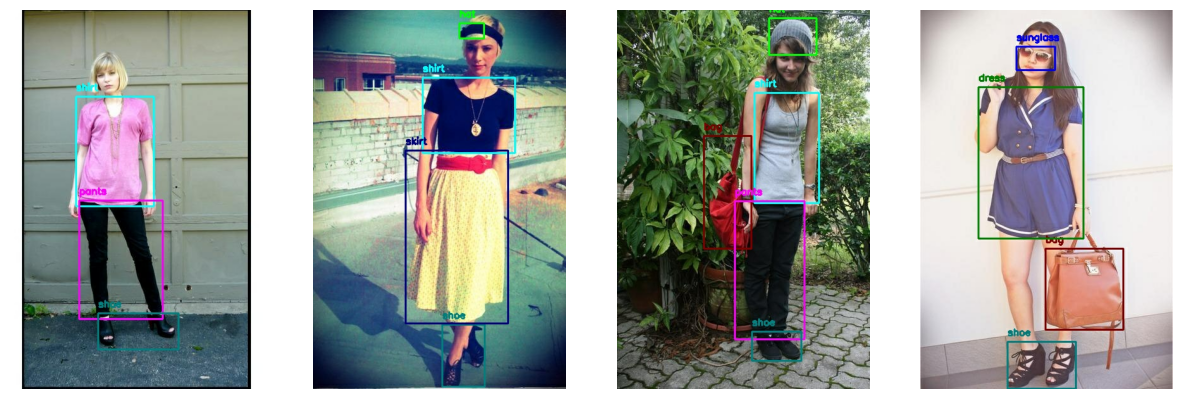

In [8]:
image_iterator = iter(image_dataset)
batch_images = next(image_iterator)

num_images_to_display = 4

plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

<a name='2.2'></a>
<h3>&sect;2.2: Categorieën</h3>

- 0 = sunglass
- 1 = hat
- 2 = jacket
- 3 = shirt
- 4 = pants
- 5 = shorts
- 6 = skirt
- 7 = dress
- 8 = bag
- 9 = shoe

In [9]:
category_names = ["sunglass", "hat", "jacket", "shirt", "pants", "shorts", "skirt",
                  "dress", "bag", "shoe"]
matching_images = find_images_by_categories(category_names)

In [10]:
count = 0
max_images = 10
for image_file, categories in matching_images.items():
    image_path = os.path.join(output_folder, image_file)
    image = cv2.imread(image_path)
    if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Categories: {", ".join(categories)}')
        plt.axis('off')
        plt.show()
        
        count += 1
        if count >= max_images:
            break

Het valt op dat de meeste schoenen in de dataset worden gerepresenteerd door hakken of sandalen. Het zou dus kunnen dat sneakers moeilijker te herkennen zijn als schoenen. Ook valt het op dat sommige bounding boxes van tassen staan op de "strap" van de tas in plaats van de tas zelf. Ook zie je enkel handtassen en schoudertassen in de dataset. Dit kan een probleem worden wanneer iemand een rugzak op heeft, die misschien niet herkent wordt als tas. Verder zijn er nu twee foto's weergegeven met een zonnebril waarvan de ene gedragen wordt in het gezicht en de ander in de hand. Dit is goed, omdat er zo niet alleen zonnebrillen op iemands hoofd zitten. De vorm van de zonnebril wordt zo makkelijker herkent, omdat het op meerdere manieren wordt weergegeven.

<a name='2.3'></a>
<h3>&sect;2.3: Afbeeldingen image-captioning</h3>

In [11]:
dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")

Generating train split: 100%|██████████| 12437/12437 [00:04<00:00, 2742.99 examples/s]


Hier laden we de dataset van Hugging Face en in de cel hieronder worden een aantal foto's laten zien met hun bijbehorende captions.

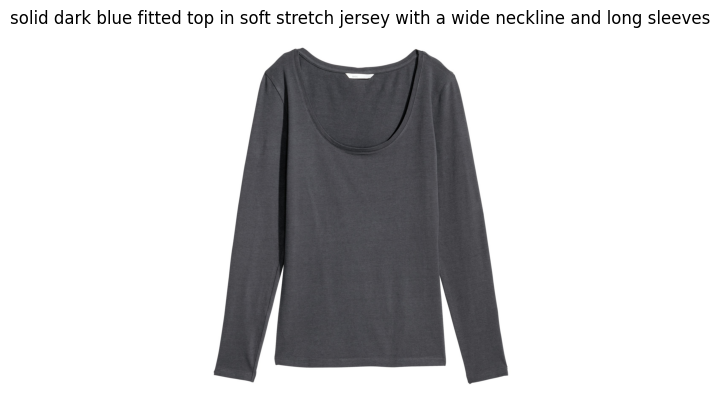

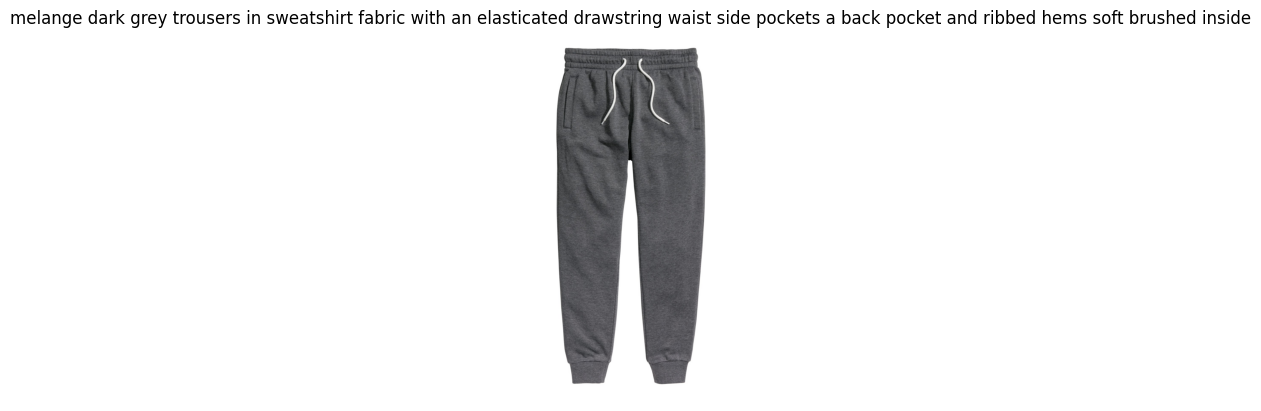

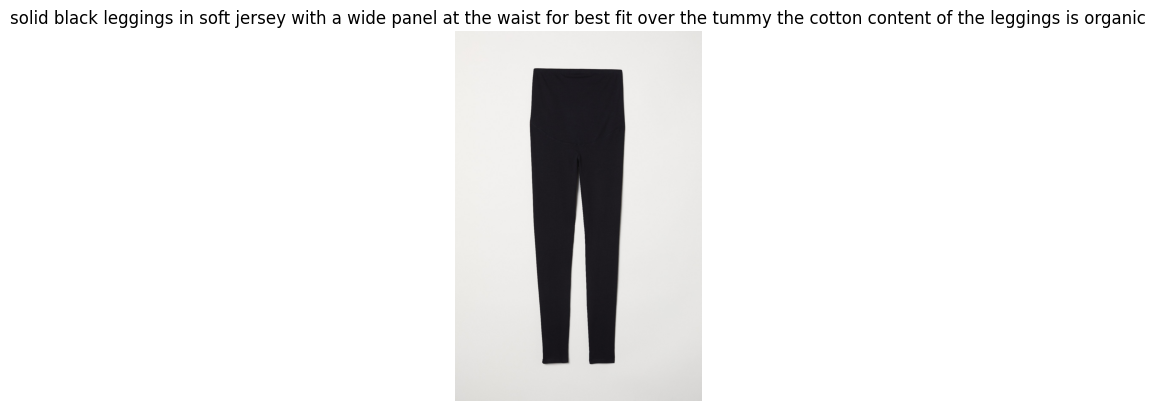

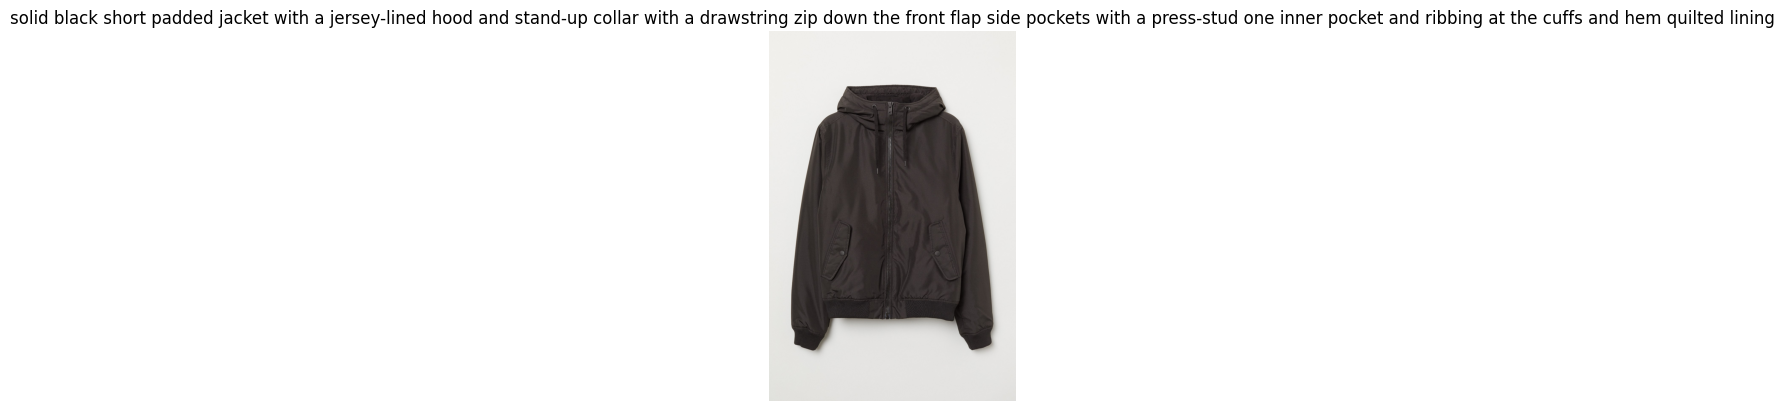

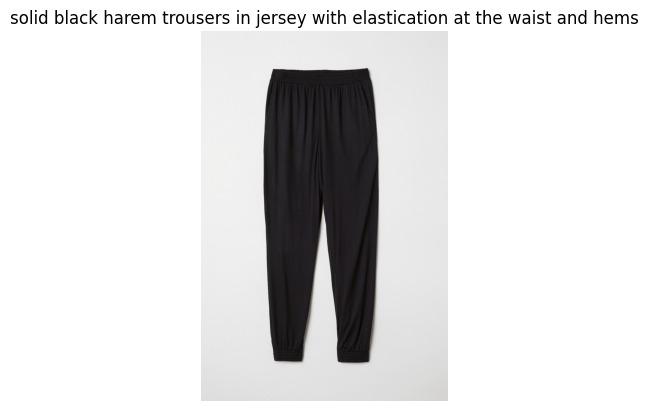

In [12]:
def display_image_and_caption(example):
    image = example['image'].convert("RGB")
    caption = example['text']
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()
    
for i in range(5):
    display_image_and_caption(dataset['train'][i])

<a name='2.4'></a>
<h3>&sect;2.4: Gemeenschappelijke items</h3>

Om te kijken of er gemeenschappelijke items aanwezig zijn in de dataset zullen we eerst de teksten bekijken die horen bij de foto's van de Hugging Face dataset. Daarna bekijken we of alle categoriën uit de Kaggle dataset ook aanwezig zijn in de Hugging Face dataset om er achter te komen of er gemeenschappelijke categoriën aanwezig zijn in de datatset.

In [13]:
descriptions = pd.DataFrame(dataset["train"]["text"])
descriptions

,0
0,solid dark blue fitted top in soft stretch jer...
1,melange dark grey trousers in sweatshirt fabri...
2,solid black leggings in soft jersey with a wid...
3,solid black short padded jacket with a jersey-...
4,solid black harem trousers in jersey with elas...
...,...
12432,all over pattern beige fitted calf-length dres...
12433,all over pattern beige fitted top in jersey wi...
12434,solid black loose-fitting sports vest top in r...
12435,solid black short a-line dress in jersey with ...


In [14]:
category_names_dataset1 = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt',
                           'dress', 'bag', 'shoe']

all_texts_dataset2 = descriptions[0].values.tolist()

category_presence = {}

for category in category_names_dataset1:
    presence = False
    for text in all_texts_dataset2:
        if category.lower() in text.lower():
            presence = True
            break
    category_presence[category] = presence

for category, presence in category_presence.items():
    print(f"{category}: {'Present' if presence else 'Not present'} in Hugging Face dataset")

sunglass: Not present in Hugging Face dataset
hat: Present in Hugging Face dataset
jacket: Present in Hugging Face dataset
shirt: Present in Hugging Face dataset
pants: Present in Hugging Face dataset
shorts: Present in Hugging Face dataset
skirt: Present in Hugging Face dataset
dress: Present in Hugging Face dataset
bag: Present in Hugging Face dataset
shoe: Not present in Hugging Face dataset


Er wordt gekeken naar de aanwezigheid van de categoriën uit de Kaggle dataset in de dataset van Hugging Face. We zien dat er twee categoriën zijn die niet in de Hugging Face dataset zitten. Dat is de zonnebril en de schoenen. Alle andere kledingstukken komen voor in beide datasets. Het is dus een goede dataset om te gebruiken, omdat het veel kledingstukken zou moeten herkennen.

<a name='2.5'></a>
<h3>&sect;2.5: Bevindingen EDA</h3>

Bij het uitvoeren van de EDA hebben we gekeken naar twee verschillende datasets. Een dataset vol met foto's van vrouwen met bounding boxes die aangeven wat er gedragen wordt. En een andere dataset vol met kleding die verkocht wordt bij de H&M. Een groot verschil tussen deze datasets is de afwezigheid van een persoon in de H&M dataset. Dit zijn foto's van een enkel kledingstuk, niet gedragen door een persoon, terwijl de andere dataset foto's bevat van vrouwen die kleding dragen met meerdere categoriën aanwezig in één enkele foto. Het model zal dan ook minder goed werken wanneer het wordt gebruikt voor een foto van een man, omdat deze niet in de dataset aanwezig zijn. Wel zou het model enkele categoriën kunnen herkennen bij een man, omdat een broek altijd gedragen wordt aan de benen en een shirt aan het boven lichaam. Een man in "vrouwelijke" kleding zou beter voorspeld worden. Ook zagen we dat er twee categoriën zijn die niet gemeenschappelijk in beide datasets zitten. Dit zijn de zonnebril en de schoenen. Het zou dus nog lastig kunnen worden om deze twee categoriën goed te voorspellen. Wel zijn de opdrachten gescheiden met het gebruik van data, dus zou dit geen probleem moeten worden.

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Object detectie</strong></h2>
</div>

<a name='3.1'></a>
<h3>&sect;3.1: Model</h3>

<a name='3.2'></a>
<h3>&sect;3.2: Voorspellingen</h3>

<a name='3.3'></a>
<h3>&sect;3.3: Afbeeldingen voorverwerken</h3>

<a name='3.4'></a>
<h3>&sect;3.4: Stappen feature engineering</h3>

<a name='3.5'></a>
<h3>&sect;3.5: Keuzes parameters, optimizer en epochs</h3>

<a name='3.6'></a>
<h3>&sect;3.6: Loss functie</h3>

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Ondertiteling van afbeeldingen</strong></h2>
</div>

<a name='4.1'></a>
<h3>&sect;4.1: Finetuning model</h3>

<a name='4.2'></a>
<h3>&sect;4.2: Uitleg model</h3>

<a name='4.3'></a>
<h3>&sect;4.3: Keuzes parameters, optimizer en epochs</h3>

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Beeld generatie</strong></h2>
</div>

<a name='5.1'></a>
<h3>&sect;5.1: Hugging Face model</h3>

<a name='5.2'></a>
<h3>&sect;5.2: Naam modelarchitectuur en dataset</h3>

<a name='5.3'></a>
<h3>&sect;5.3: Stappen finetunen</h3>

<a name='5.4'></a>
<h3>&sect;5.4: Componenten model</h3>

<a name='5.5'></a>
<h3>&sect;5.5: Afbeeldingen maken en loss functie</h3>

<a name='5.6'></a>
<h3>&sect;5.6: Keuzes parameters, optimizer en epochs</h3>

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Implementatie</strong></h2>
</div>

<a name='6.1'></a>
<h3>&sect;6.1: App</h3>

In [5]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Load the object detection model
object_detection_model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Load the image captioning model
image_captioning_model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
def detect_objects(image):
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 224.0
    image = tf.expand_dims(image, axis=0)

    # Perform object detection
    predictions = object_detection_model.predict(image)

    # Get the bounding box coordinates and class labels
    boxes = predictions['detection_boxes'][0].numpy()
    classes = predictions['detection_classes'][0].numpy().astype(int)
    scores = predictions['detection_scores'][0].numpy()

    # Filter out low-confidence detections
    threshold = 0.5
    filtered_boxes = boxes[scores >= threshold]
    filtered_classes = classes[scores >= threshold]

    return filtered_boxes, filtered_classes

def generate_description(image):
    # Preprocess the image
    image = tf.keras.applications.vgg19.preprocess_input(image)

    # Generate image caption
    caption = image_captioning_model.predict(image)
    caption = caption[0].strip()

    return caption

def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Detect objects in the image
    boxes, classes = detect_objects(image)

    # Generate descriptions for each object
    descriptions = []
    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = boxes[i]
        class_label = category_names[classes[i]]
        description = f"{class_label}: ({x_min}, {y_min}) - ({x_max}, {y_max})"
        descriptions.append(description)

    # Generate an overall description for the image
    image_description = generate_description(image)

    return descriptions, image_description

# Example usage
image_path = 'C:/Users/akers/OneDrive/Documenten/Train/images/1.jpg'
descriptions, image_description = process_image(image_path)

# Display the image with bounding boxes and descriptions
image = cv2.imread(image_path)
for description in descriptions:
    print(description)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(image_description)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 101ms/step


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<a name='6.2'></a>
<h3>&sect;6.2: Samenvatting uitkomsten modelleren</h3>

<a name='6.3'></a>
<h3>&sect;6.3: Overzicht resultaten</h3>

<a name='6.4'></a>
<h3>&sect;6.4: Kaggle scores</h3>

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Conclusie en aanbevelingen</strong></h2>
</div>

<a name='7.1'></a>
<h3>&sect;7.1: Uitdagingen en omschrijving modelleringsproces</h3>

<a name='7.2'></a>
<h3>&sect;7.2: Aanbevolen gebruik</h3>

<a name='7.3'></a>
<h3>&sect;7.3: Aanbevelingen soort data</h3>

<a name='7.4'></a>
<h3>&sect;7.4: Resultaten betrouwbaar?</h3>

[Back to the top](#start)
<a name='8.0'></a>

<div style="background-color:#880E4F; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Literatuurlijst</strong></h2>
</div>